In [90]:
import os
import sys
import types
import itertools
import json

import pydocumentdb.documents as documents
import pydocumentdb.document_client as document_client
import pydocumentdb.errors as errors
import pydocumentdb.http_constants as http_constants

import pandas as pd; pd.options.display.max_rows =400
import pandasql as sqldf
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np

import view.config as cfg
import view.storage as st
import view.normalization as norm
import view.analyze as ana

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

from IPython.core.display import HTML
from IPython.display import display

In [2]:
HOST = cfg.settings.host
MASTER_KEY = cfg.settings.master_key
DATABASE_ID = cfg.settings.database_id
COLLECTION_ID = cfg.settings.collection_id
COLLECTION_ID ="causality1"

In [4]:
res_names = ["procured_reserves", "accepted_offers", "insufficients_offers", "activated_offers", "peak_daily_margins"]

### 1. Get Data From Cosmos

In [196]:
client = document_client.DocumentClient(HOST, {'masterKey': MASTER_KEY})

coll_link = st.GetCollectionLink(client, DATABASE_ID, COLLECTION_ID)
proc_id = "ReadResources"

options = { 'enableScriptLogging': True }
params = {
    "resources": res_names, 
    "start": "2015-01-18T00:00:00+02:00",
    "end": "2017-06-31T23:30:00+01:00",
    "options" : {
        "pageSize":-1
    }
}

dodocs = st.ExecuteProcedure( client, coll_link, proc_id, params, options )

None


### 2. Concatenate Data

In [197]:
data = []

for key, value in dodocs.iteritems():
    df = pd.DataFrame(value)
    df["resource"] = key
    df["alert"] = "NORMAL"
    df["downgraded"] = "NORMAL"
    data.append(df)

data = norm.FindProbableFloat(data)
df = pd.concat(data, axis=0)
# Set date columns as normalized datetime columns
df[["start_date", "end_date"]]= df[["start_date", "end_date"]].astype(np.datetime64)
df = df[df.start_date < df.end_date]

### 3. Propagage peak_daily_margins and insufficients_offers

In [198]:
for index, row in df[df.resource == "insufficients_offers"].iterrows():
    if row.type == "DOWNGRADED":
        condition = np.logical_and(df.start_date >= row.start_date, df.start_date < row.end_date)
        df.loc[condition, "downgraded"] = row.nature
    elif row.type == "WARNING":
        condition = np.logical_and(df.start_date >= row.start_date, df.start_date < row.end_date)
        df.loc[condition, "alert"] = row.nature

indexs = []
df3 = pd.DataFrame([])
for index, row in df[df.resource == "peak_daily_margins"].iterrows():
    
    start = pd.date_range(start=row.start_date, end=row.end_date, freq='30T', closed='left')
    end = pd.date_range(start=row.start_date, end=row.end_date, freq='30T', closed='right')
    
    do = df[df.start_date == row.start_date]
    distance = do[do.resource == "accepted_offers"].direction.unique()
    
    row.direction = distance[0] if len(distance)>0 else "UP_DOWN"
    
    df2 = pd.concat([row]*len(start), ignore_index=True, axis=1).T
    
    df2.start_date = start
    df2.end_date = end
    
    df3 = df3.append(df2)
    indexs.append(index)

df = df.drop(df.index[[indexs]])
df = df.append(df3, ignore_index=True)

### 4. Drop useles data

In [199]:
# Drop Rows
df = df[df.resource != "insufficients_offers"]

### 5. Reshape dataframe

In [200]:
valueList = ["available_value","price", "required_value", "value"]
print valueList
# Set Categorical columns
#categoryList = list(df.select_dtypes(include=["object"]).columns)
#df[categoryList] = df[categoryList].apply(lambda x: x.astype('category'), axis=1)

divider = getattr(cfg.groups, "balancing_capacity")
NumberTypes = (types.IntType, types.LongType, types.FloatType, types.ComplexType)
if not valueList ==[] :
    table_df = pd.pivot_table(
                df,
                values=valueList,
                index=['start_date','end_date','resource','type','direction','alert','downgraded'],
                aggfunc= 'first')
    
    # Go from multi columns to cube
    level = 7
    table_df = table_df.stack(0).reset_index(level)
    table_df = table_df.rename(index=str, columns={"level_"+str(level): "value_type"})
    
    # Set date columns as normalized datetime columns
    table_df = table_df.reset_index()
    table_df[["start_date", "end_date"]]= table_df[["start_date", "end_date"]].astype(np.datetime64)
    
    
    # Set multi index dataframe
    table_df = table_df.set_index(['start_date','end_date','resource','type','direction','alert','downgraded',"value_type"])
    table_df = table_df.rename(index=str, columns={0:"value"})
    

['available_value', 'price', 'required_value', 'value']


In [187]:
table_df

value
start_date          end_date            resource           type    direction alert  downgraded value_type               
2015-01-17 23:00:00 2015-01-17 23:30:00 accepted_offers    AFRR    UP_DOWN   NORMAL NORMAL     value              802.00
                                        procured_reserves  AFRR    UP_DOWN   NORMAL NORMAL     price                9.16
                                                                                               value              750.00
2015-01-17 23:30:00 2015-01-18 00:00:00 accepted_offers    AFRR    UP_DOWN   NORMAL NORMAL     value              767.00
                                        procured_reserves  AFRR    UP_DOWN   NORMAL NORMAL     price                9.16
                                                                                               value              700.00
2015-01-18 00:00:00 2015-01-18 00:30:00 accepted_offers    AFRR    UP_DOWN   NORMAL NORMAL     value              850.00
                                                           FCR     UP_DOWN   NORMAL NORMAL     value              634.00
                                        procured_reserves  AFRR    UP_DOWN   NORMAL NORMAL     price                9.16
                                                                                               value              700.00
                                                           FCR     UP_DOWN   NORMAL NORMAL     price                9.16
                                                                                               value              573.00
2015-01-18 00:30:00 2015-01-18 01:00:00 accepted_offers    AFRR    UP_DOWN   NORMAL NORMAL     value              780.00
                                                           FCR     UP_DOWN   NORMAL NORMAL     value              649.00
                                        procured_reserves  AFRR    UP_DOWN   NORMAL NORMAL     price                9.16
                                                                                               value              700.00
                                                           FCR     UP_DOWN   NORMAL NORMAL     price                9.16
                                                                                               value              573.00
2015-01-18 01:00:00 2015-01-18 01:30:00 accepted_offers    AFRR    UP_DOWN   NORMAL NORMAL     value              765.00
                                                           FCR     UP_DOWN   NORMAL NORMAL     value              646.00
                                        procured_reserves  AFRR    UP_DOWN   NORMAL NORMAL     price                9.16
                                                                                               value              650.00
                                                           FCR     UP_DOWN   NORMAL NORMAL     price                9.16
                                                                                               value              573.00
2015-01-18 01:30:00 2015-01-18 02:00:00 accepted_offers    AFRR    UP_DOWN   NORMAL NORMAL     value              699.00
                                                           FCR     UP_DOWN   NORMAL NORMAL     value              647.00
                                        procured_reserves  AFRR    UP_DOWN   NORMAL NORMAL     price                9.16
                                                                                               value              650.00
                                                           FCR     UP_DOWN   NORMAL NORMAL     price                9.16
                                                                                               value              573.00
2015-01-18 02:00:00 2015-01-18 02:30:00 accepted_offers    AFRR    UP_DOWN   NORMAL NORMAL     value              745.00
                                                           FCR     UP_DOWN   NORMAL NORMAL     value              644.00
 

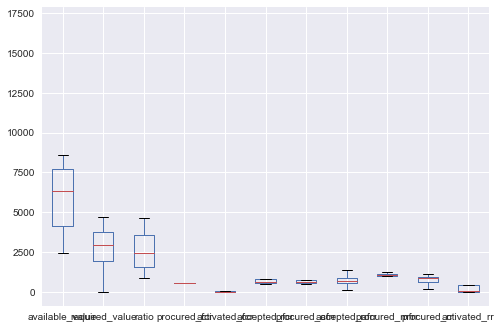

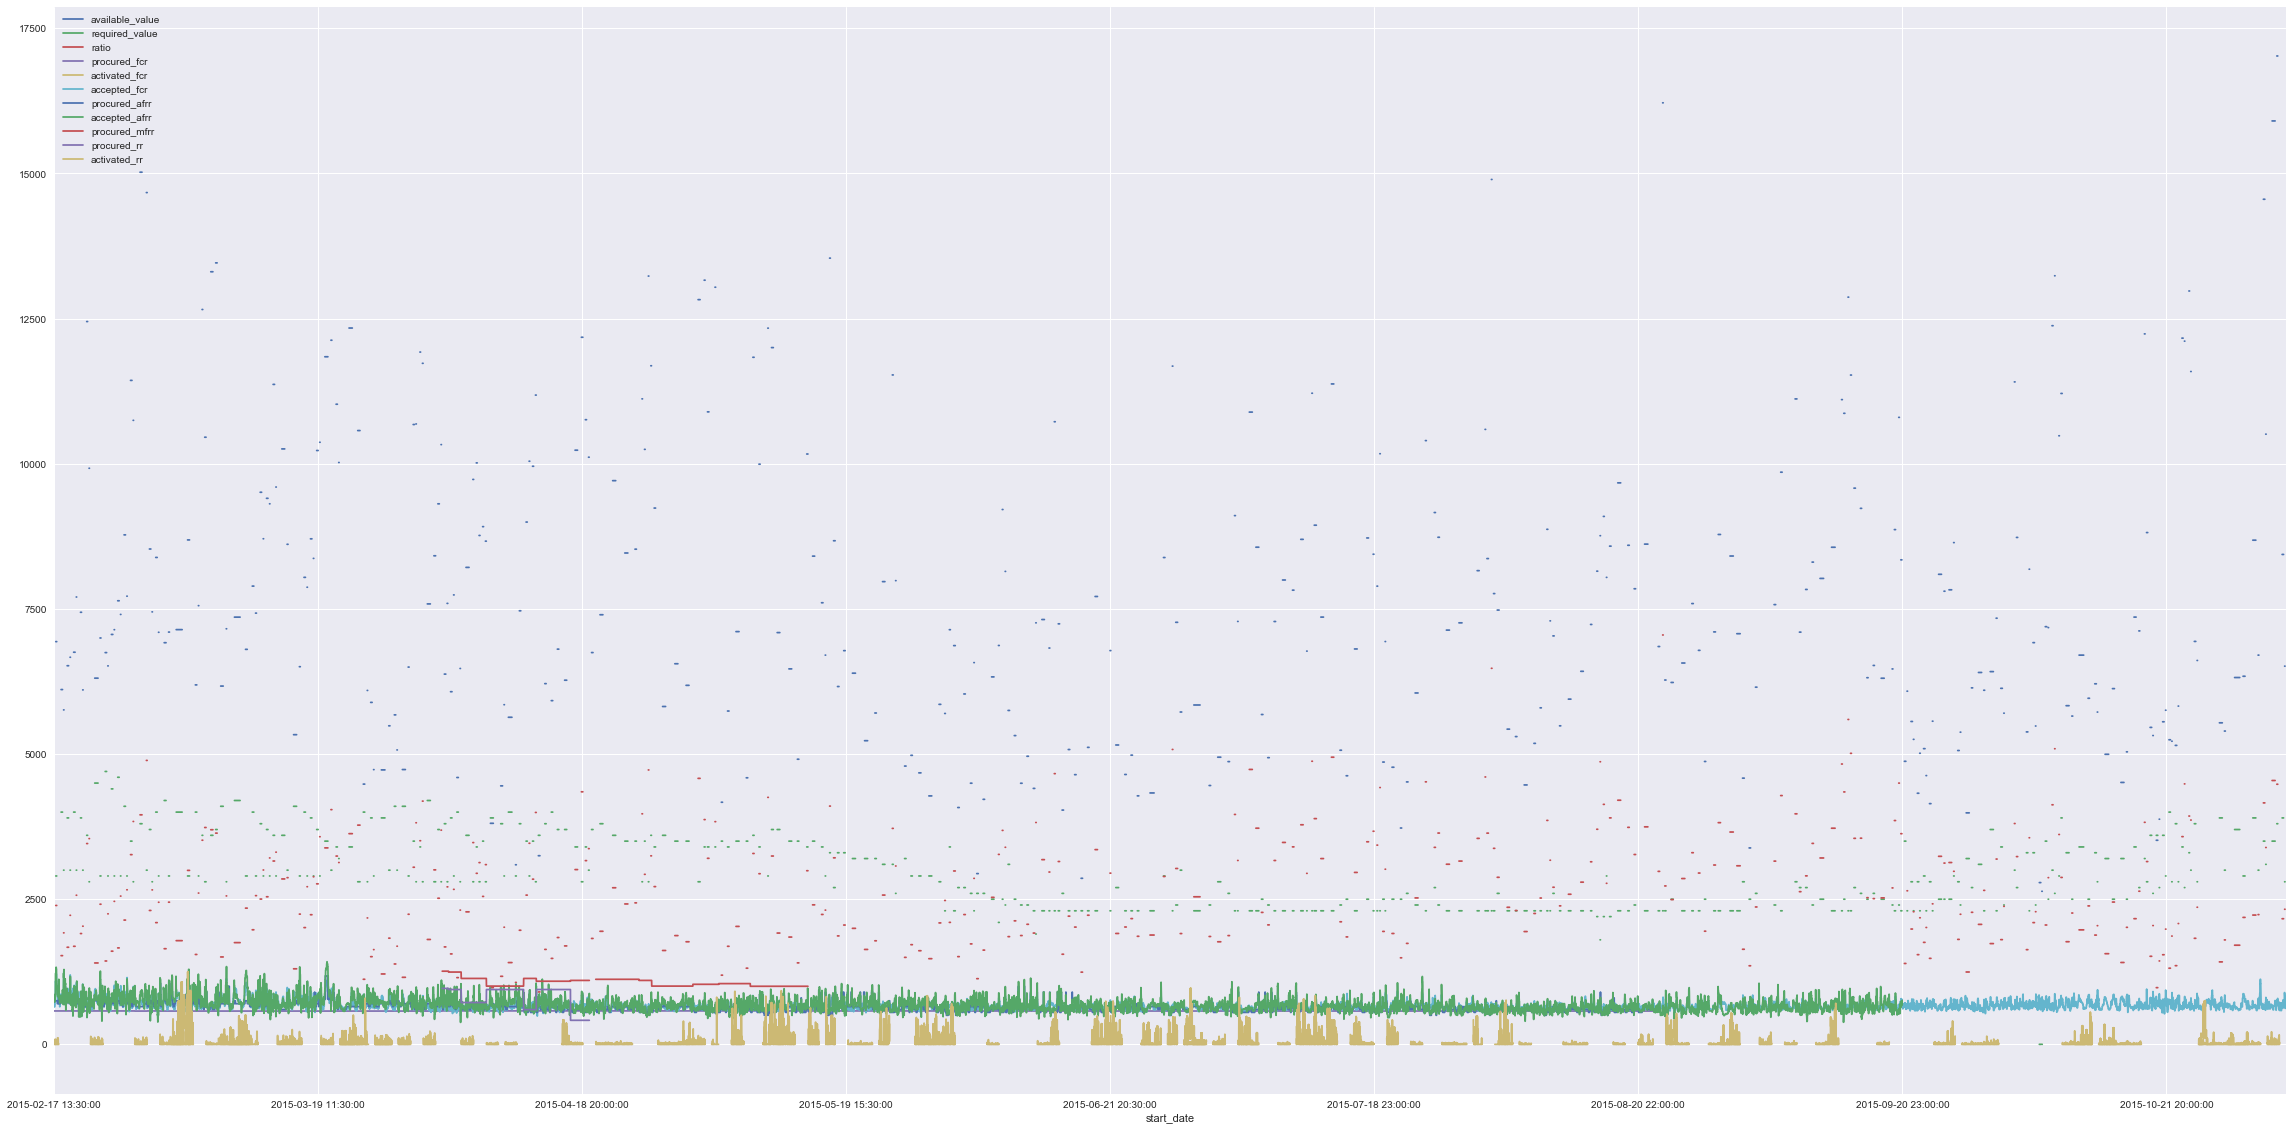

In [209]:

q2 = """
    select distinct
        i.start_date,
        i.direction,
        i.resource,
        i.alert,
        i.downgraded,
        a.value as available_value,
        r.value as required_value,
        a.value/r.value * 1000 as ratio,
        
        prfcr.value as procured_fcr,
        actofcr.value as activated_fcr,
        accofcr.value as accepted_fcr,
        
        prafrr.value as procured_afrr,
        actoafrr.value as activated_afrr,
        accoafrr.value as accepted_afrr,
        
        prm.value as procured_mfrr,
        actom.value as activated_mfrr,
        accom.value as accepted_mfrr,
        
        prrr.value as procured_rr,
        actorr.value as activated_rr,
        accorr.value as accepted_rr
    from 
        table_df as i
        
        
    left join
        (select * from table_df as t where t.resource = 'peak_daily_margins' and t.value_type = 'required_value') as r
            on i.start_date = r.start_date
    left join
        (select * from table_df as t where t.resource = 'peak_daily_margins' and t.value_type = 'available_value') as a
            on i.start_date = a.start_date
            
            
    left join
        (select * from table_df as t where t.resource = 'procured_reserves' and t.value_type = 'value' and t.type='FCR') as prfcr
            on i.start_date = prfcr.start_date
    left join
        (select * from table_df as t where t.resource = 'activated_offers' and t.value_type = 'value' and t.type='FCR') as actofcr
            on i.start_date = actofcr.start_date
    left join
        (select * from table_df as t where t.resource = 'accepted_offers' and t.value_type = 'value' and t.type='FCR') as accofcr
            on i.start_date = accofcr.start_date
            
            
    left join
        (select * from table_df as t where t.resource = 'procured_reserves' and t.value_type = 'value' and t.type='AFRR') as prafrr
            on i.start_date = prafrr.start_date
    left join
        (select * from table_df as t where t.resource = 'activated_offers' and t.value_type = 'value' and t.type='AFRR') as actoafrr
            on i.start_date = actoafrr.start_date
    left join
        (select * from table_df as t where t.resource = 'accepted_offers' and t.value_type = 'value' and t.type='AFRR') as accoafrr
            on i.start_date = accoafrr.start_date
    
    
    left join
        (select * from table_df as t where t.resource = 'procured_reserves' and t.value_type = 'value' and t.type='MFRR') as prm
            on i.start_date = prm.start_date
    left join
        (select * from table_df as t where t.resource = 'activated_offers' and t.value_type = 'value' and t.type='MFRR') as actom
            on i.start_date = actom.start_date
    left join
        (select * from table_df as t where t.resource = 'accepted_offers' and t.value_type = 'value' and t.type='MFRR') as accom
            on i.start_date = accom.start_date
            
            
    left join
        (select * from table_df as t where t.resource = 'procured_reserves' and t.value_type = 'value' and t.type='RR') as prrr
            on i.start_date = prrr.start_date
    left join
        (select * from table_df as t where t.resource = 'activated_offers' and t.value_type = 'value' and t.type='RR') as actorr
            on i.start_date = actorr.start_date
    left join
        (select * from table_df as t where t.resource = 'accepted_offers' and t.value_type = 'value' and t.type='RR') as accorr
            on i.start_date = accorr.start_date
    where
        i.resource = 'accepted_offers' and 
        i.value_type = 'value' and
        i.type = 'FCR';
"""

query_df = sqldf(q2, locals())
query_df.set_index('start_date',inplace=True)
query_df.describe().boxplot()
query_df.plot(figsize=(40,20))
plt.show()

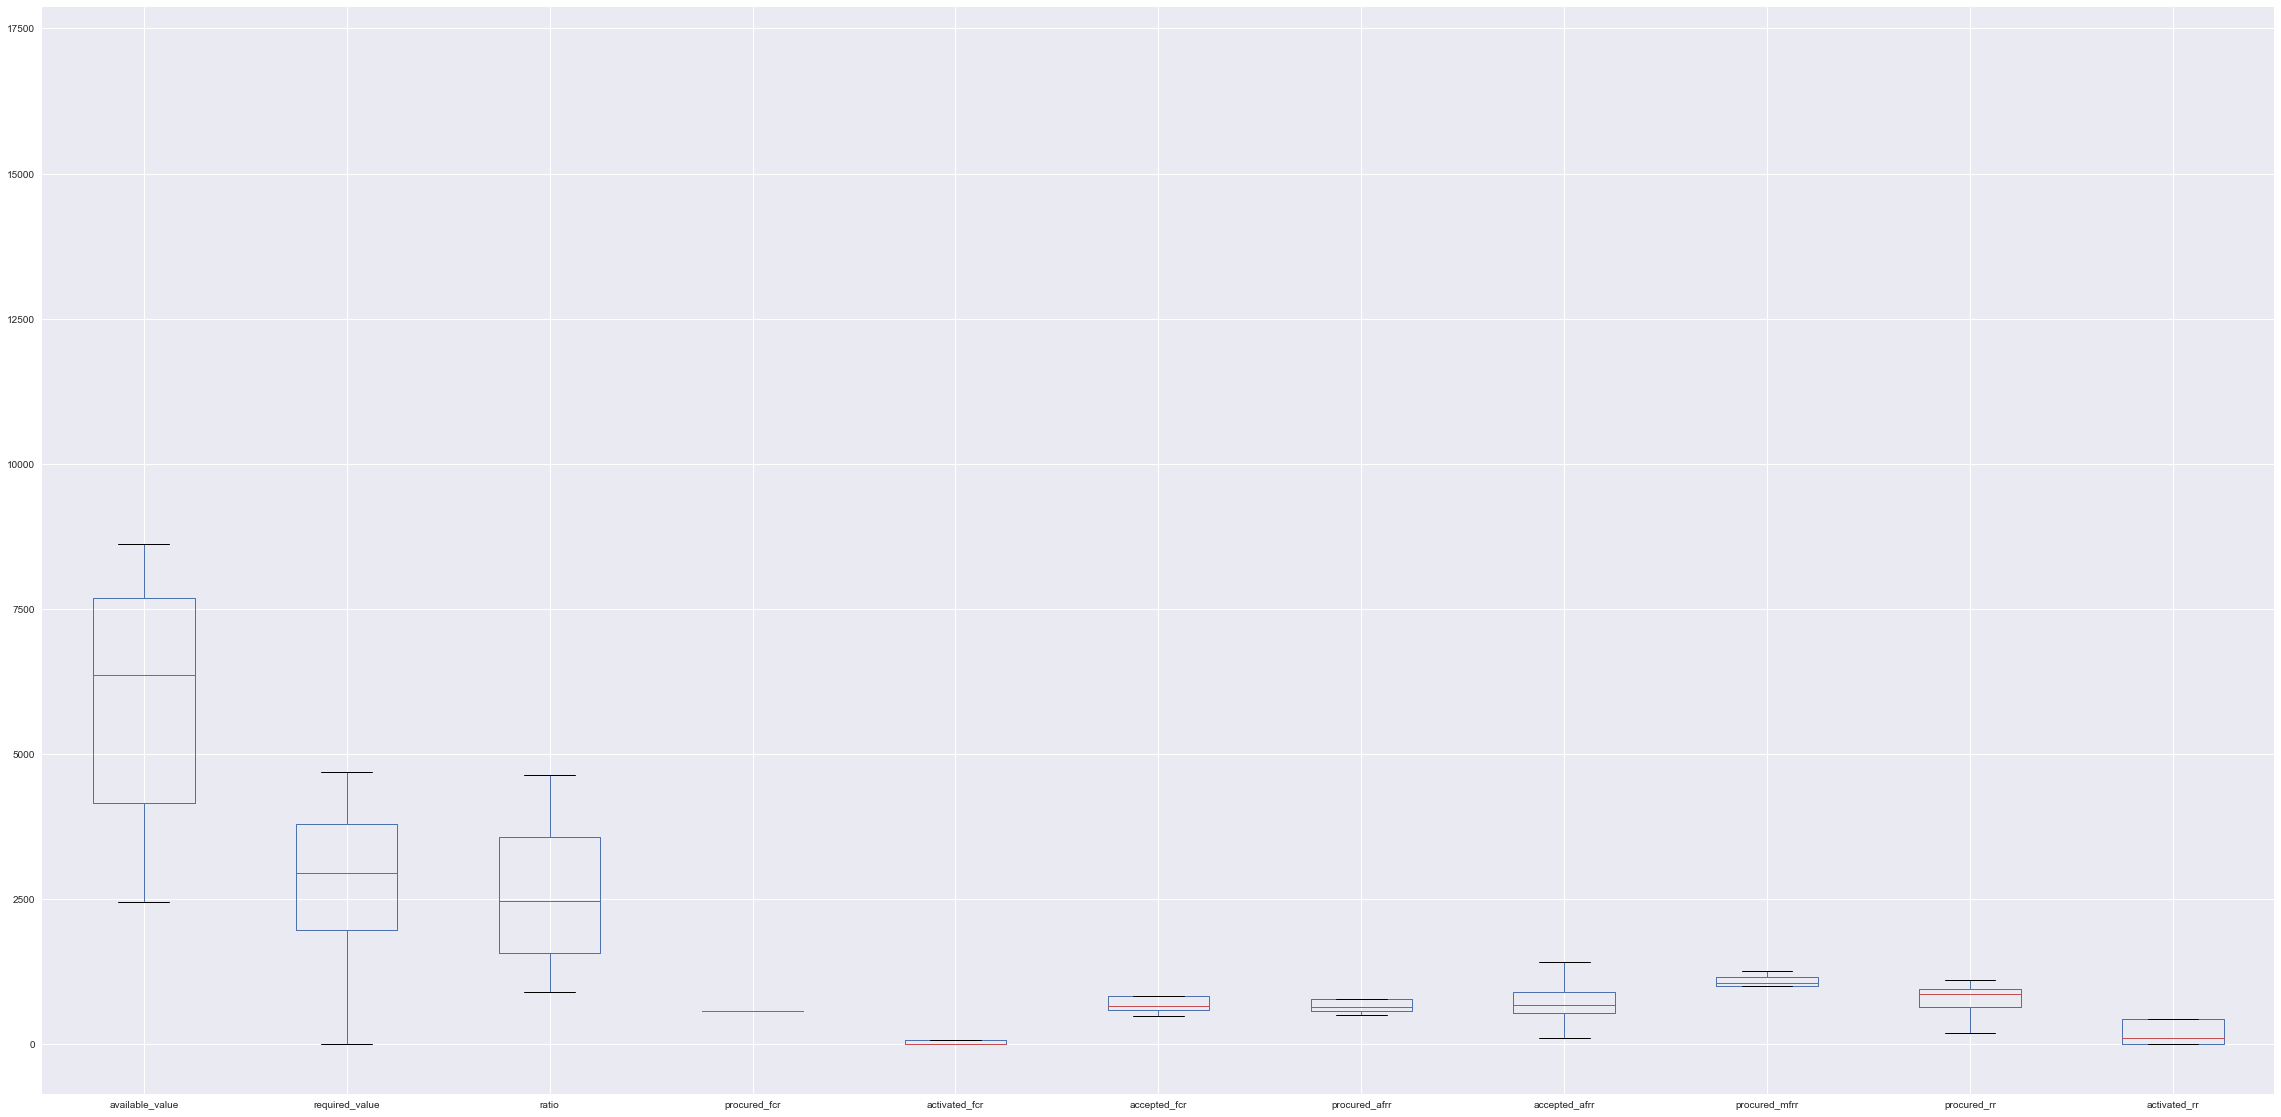

In [210]:
query_df.describe().boxplot(figsize=(40,20))
plt.show()

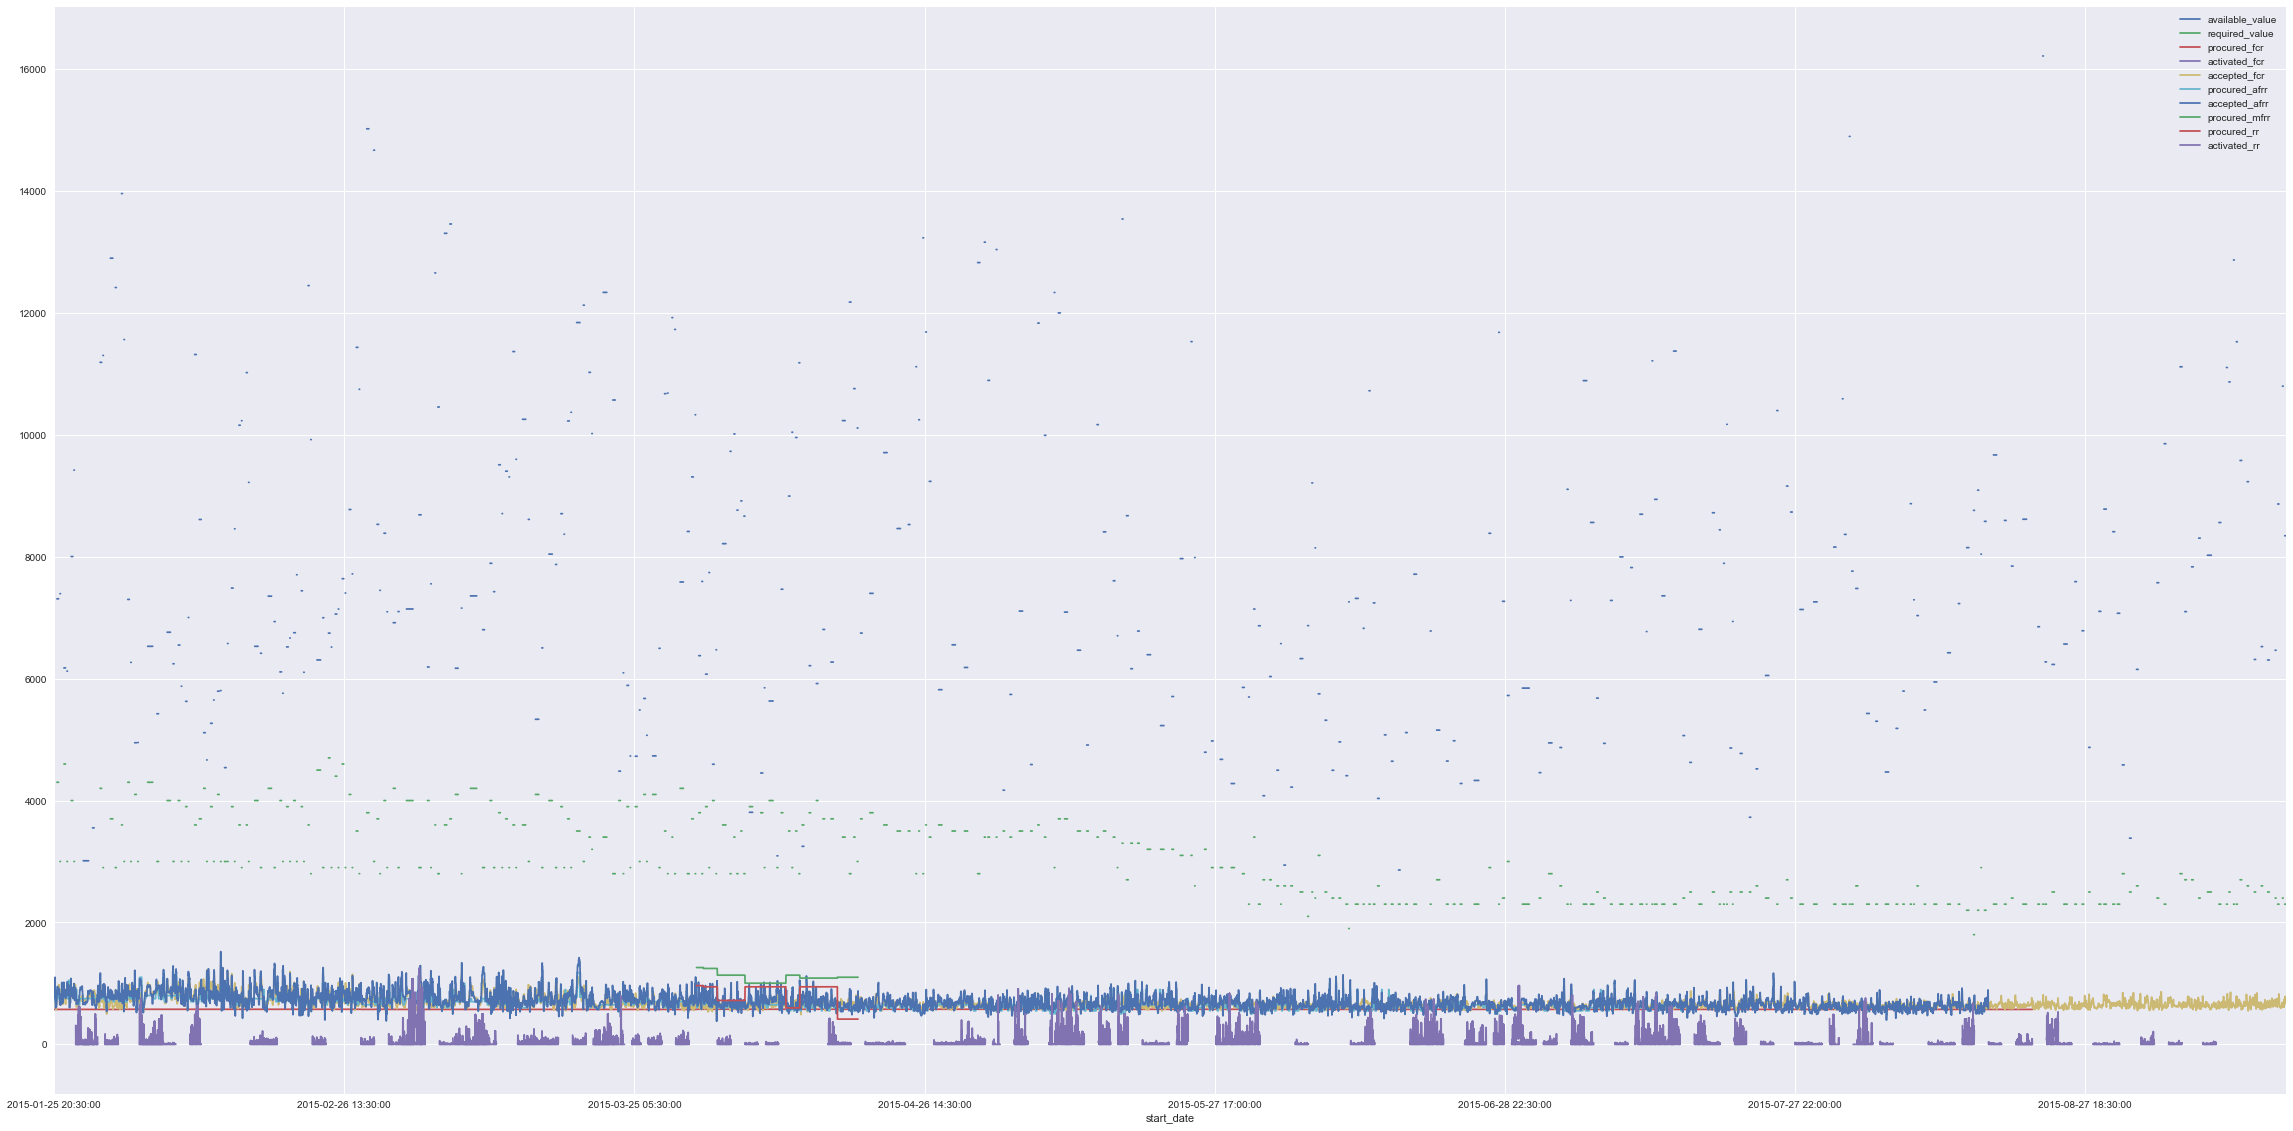

In [163]:
query_df.plot(figsize=(40,20))
plt.show()

              ratio
count  12002.000000
mean       2.420187
std        1.002616
min        0.790968
25%        1.616389
50%        2.219231
75%        3.069697
max        7.050870


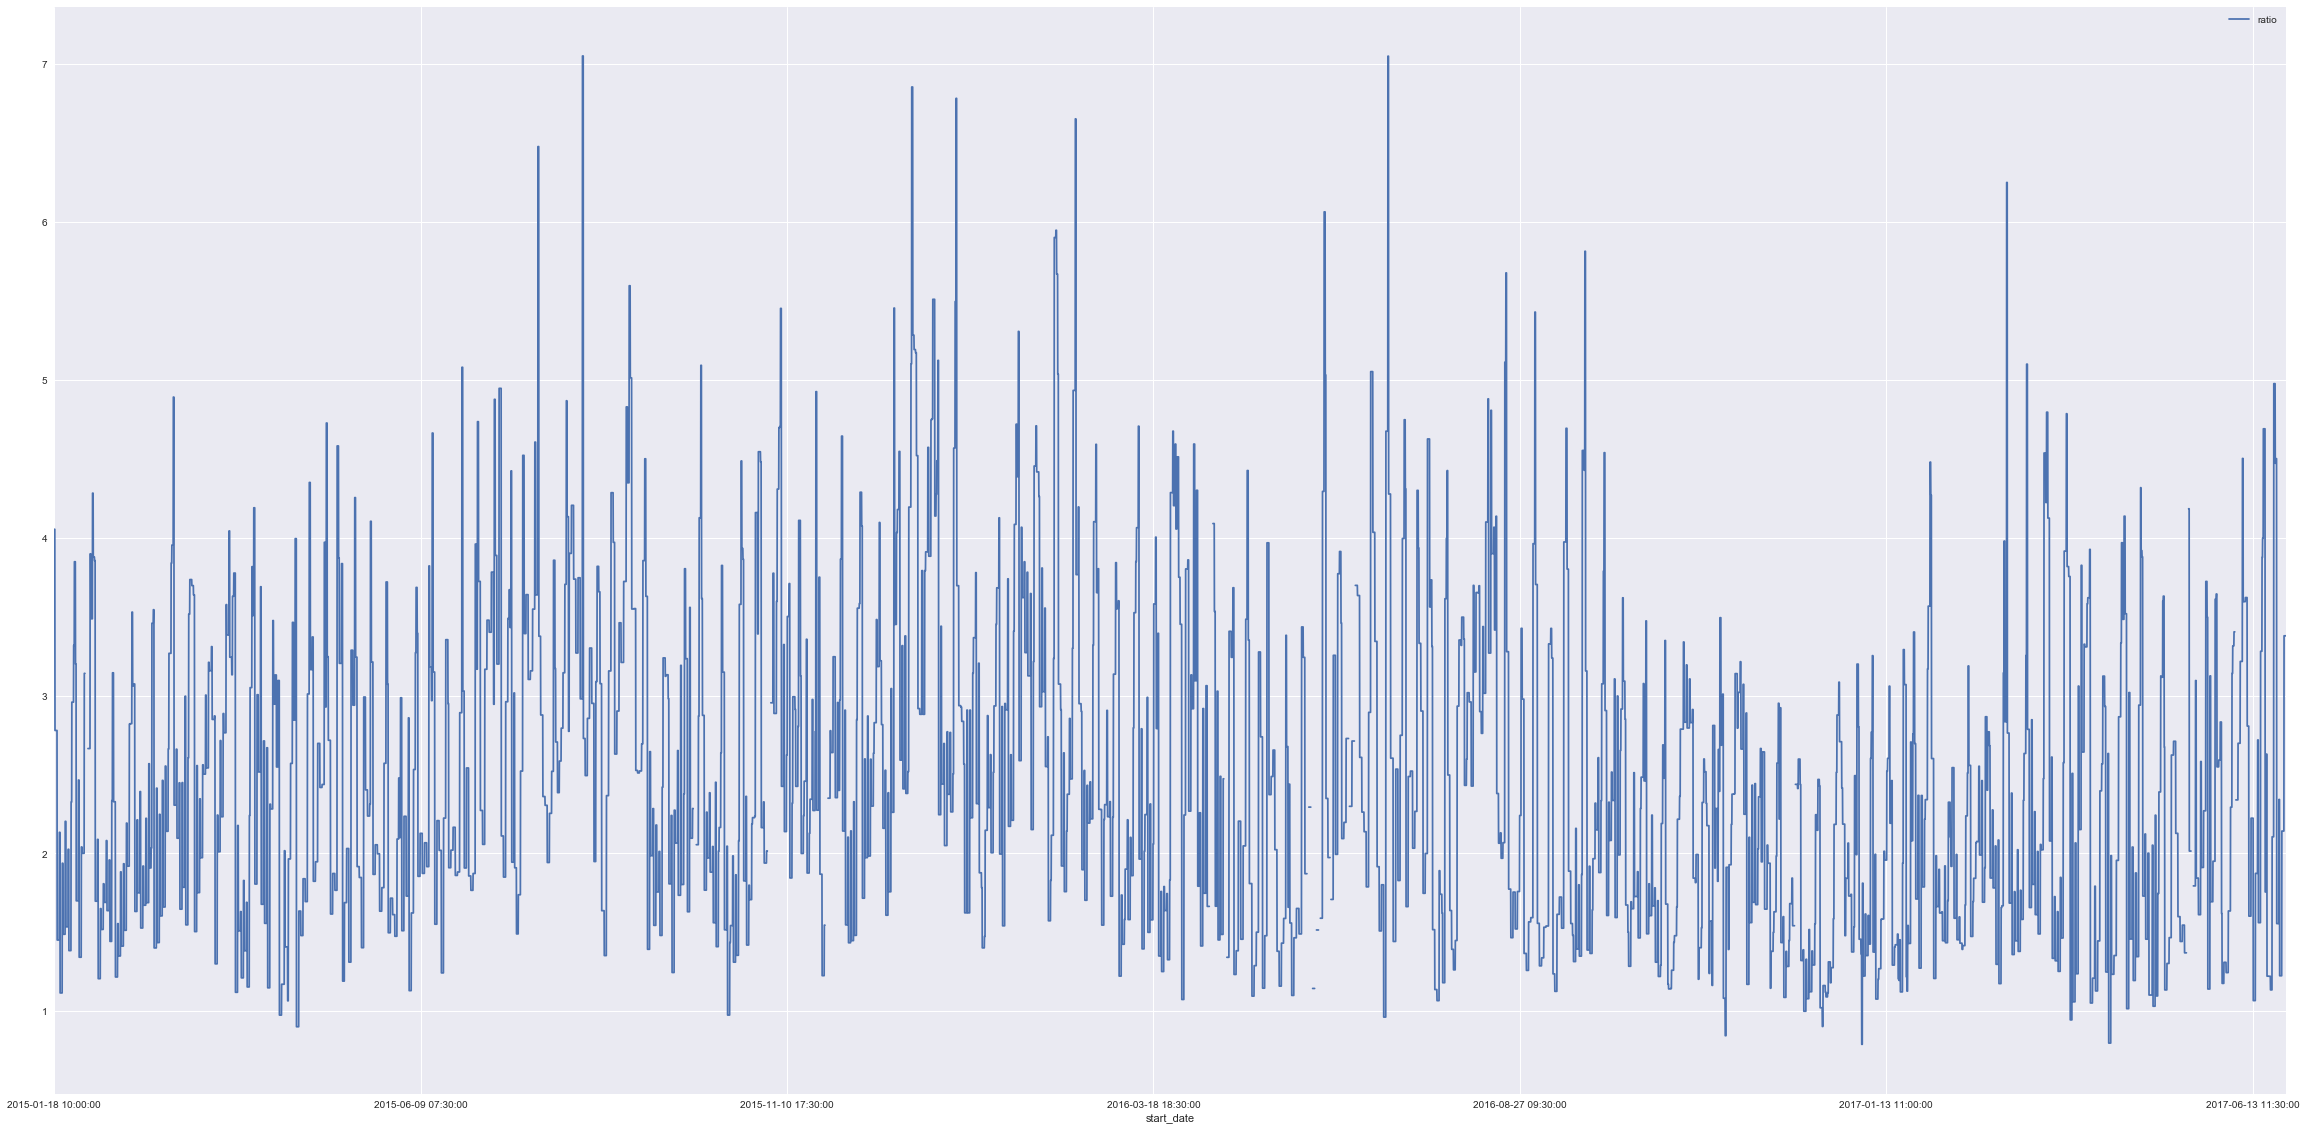

In [201]:

q2 = """
    select distinct
        i.start_date,
        i.direction,
        i.resource,
        i.alert,
        i.downgraded,
        a.value/r.value as ratio
    from 
        table_df as i
        
    left join
        (select * from table_df as t where t.resource = 'peak_daily_margins' and t.value_type = 'required_value') as r
            on i.start_date = r.start_date
    left join
        (select * from table_df as t where t.resource = 'peak_daily_margins' and t.value_type = 'available_value') as a
            on i.start_date = a.start_date
    where
        i.alert = 'NORMAL' and
        i.resource = 'peak_daily_margins' and 
        i.value_type = 'available_value';
""".format(resource="peak_daily_margins")

query_df = sqldf(q2, locals())
query_df.set_index('start_date',inplace=True)
print query_df.describe()
query_df.plot(figsize=(40,20))
plt.show()

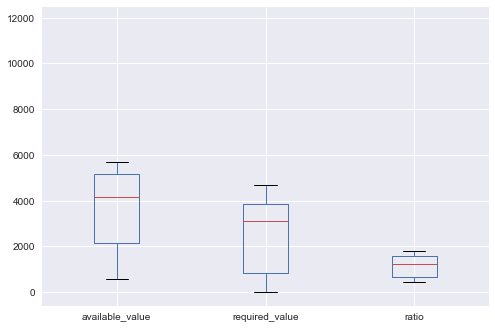

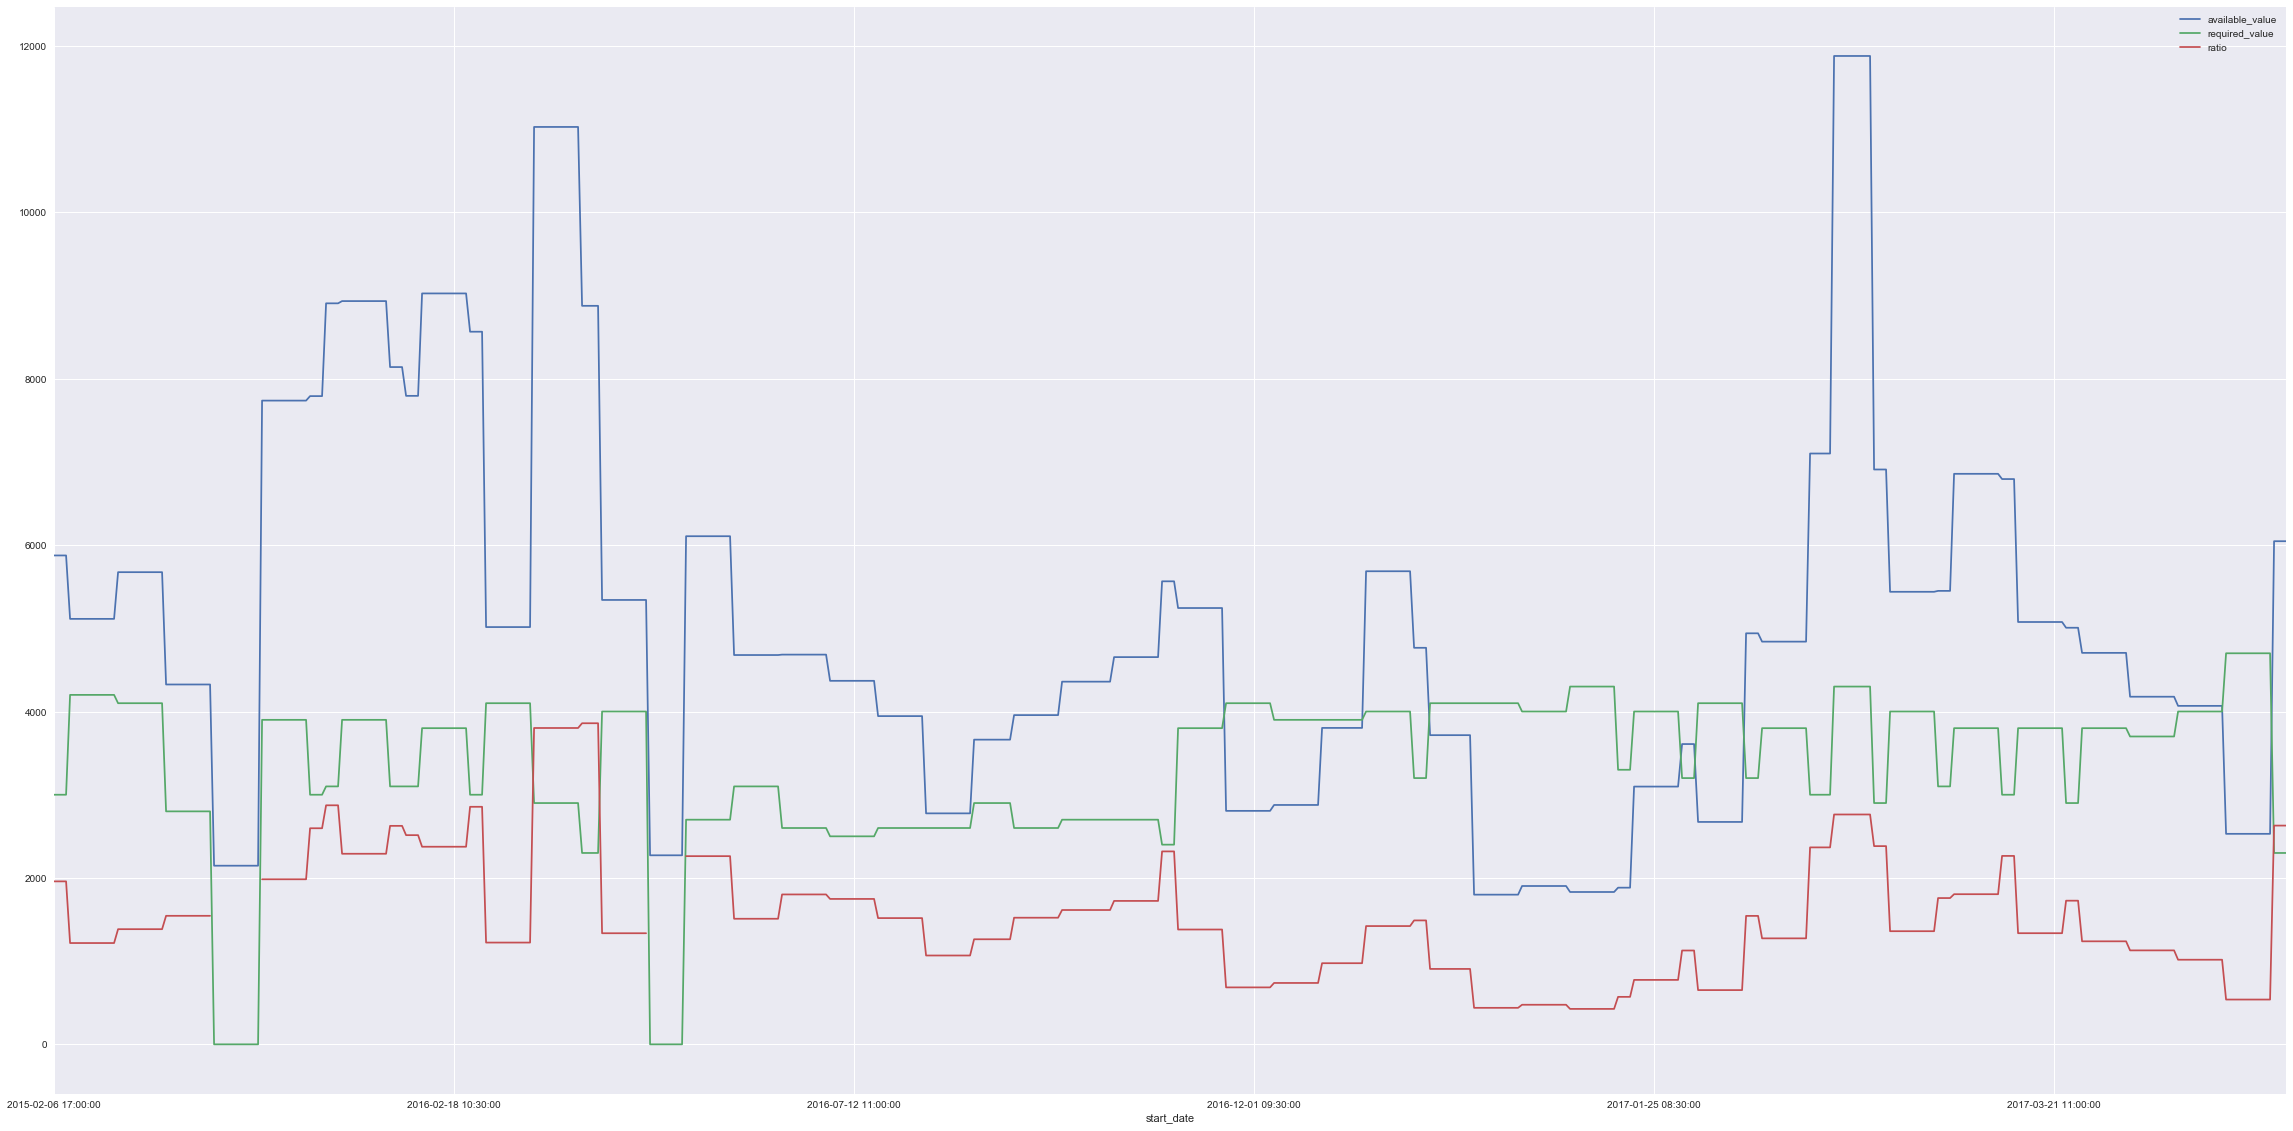

In [208]:

q2 = """
    select distinct
        i.start_date,
        i.direction,
        i.resource,
        i.alert,
        i.downgraded,
        a.value as available_value,
        r.value as required_value,
        a.value/r.value*1000 as ratio 
    from 
        table_df as i
        
    left join
        (select * from table_df as t where t.resource = 'peak_daily_margins' and t.value_type = 'required_value') as r
            on i.start_date = r.start_date
    left join
        (select * from table_df as t where t.resource = 'peak_daily_margins' and t.value_type = 'available_value') as a
            on i.start_date = a.start_date
    where
        i.downgraded = 'BALANCE_SUPPLY_DEMAND' and
        i.resource = 'peak_daily_margins' and 
        i.value_type = 'available_value';
""".format(resource="peak_daily_margins")

query_df = sqldf(q2, locals())
query_df.set_index('start_date',inplace=True)
query_df.describe().boxplot()
query_df.plot(figsize=(40,20))
plt.show()